In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import IPython.display as ipd

In [4]:
SMPL_SIZE = 256 # number of samples in each wave in the wavetable
FS = 44100 # the audio output sample rate

# min frequency of each oscillator
VCO_F_MIN, VCO_F_MAX = 40, 20000
LFO_F_MIN, LFO_F_MAX = 1/60, 1000

V_MIN, V_MAX = 0, 3.3
CCW, CW = V_MIN, V_MAX
MID = (CW - CCW) / 2

vco_mode = True

In [5]:
def bound(value, min_val, max_val):
    return max(min_val, min(value, max_val))

# lerp: linear interpolation
# wave_idx is the index into the wave sample
# returns the linearly interpolated wave value at point k
def lerp2pt(x0, y0, x1, y1, k):
    return (y0*(x1 - k) + y1*(k - x0))/(x1 - x0)

# remaps val from linear range [min_1, max_1] to linear range [min_2, max_2] 
def translate_range(val, min_1, max_1, min_2, max_2):
    range_1 = max_1 - min_1
    range_2 = max_2 - min_2
    
    if range_1 == 0:
        return 0
    
    out = (((val - min_1) * range_2) / range_1) + min_2
    return bound(out, min_2, max_2)


# interpolates between two points
# amount=0 -> wave_1, amount=1 -> wave_2
def morph1d(x1, x2, amount):
    return (1-amount)*x1 + amount*x2

# interpolates between wave_1 and wave_2
# amount=0 -> wave_1, amount=1 -> wave_2
def morph(wave_1, wave_2, amount):
    return [(1-amount)*w1 + amount*w2 for w1,w2 in zip(wave_1, wave_2)]


def listen(wave):
    display(ipd.Audio(wave, rate=FS))
          
def plot_wave(wave):
    plt.plot(wave, lw=2)


In [6]:
# wavetable shape indices
WAVE_SIN = 0
WAVE_TRI = 1
WAVE_SAW = 2
WAVE_SQR = 3

# populate a wavetable, each wave with SMPL_SIZE samples
def gen_wavetable_naive():
    wavetable = []
    t = np.linspace(0, 1, SMPL_SIZE, endpoint=False)

    x = 2*np.pi*t
    
    wavetable.append(np.sin(x)) # sine
    wavetable.append(signal.sawtooth(x + np.pi/2, 0.5)) # triangle
    wavetable.append(signal.sawtooth(x + np.pi)) # saw
    wavetable.append(signal.square(x)) # square
        
    return t, wavetable

pitches = [VCO_F_MIN*(2**i) for i in range(0,10)]
max_h = 368
max_harmonics = [int(max_h/(2**i)) for i in range(0, len(pitches))]

print(list(zip(pitches, max_harmonics)))

def gen_wavetable():
    t = np.linspace(0, 1, SMPL_SIZE, endpoint=False)
    x = 2*np.pi*t
        
    wavetable, sine_samples, tri_samples, saw_samples, square_samples = ([] for _ in range(5))
    
    for i in range(0, len(max_harmonics)):
        sine_samples.append(np.sin(x))
        
        tri_offs = saw_offs = square_offs = 0
        w_tri = w_saw = w_square = np.sin(x)
        
        num_harmonics = max_harmonics[i]
    
        for k in range(2, num_harmonics):
            if k % 2 != 0: # only odd harmonics
                # tri
                tri_offs += np.pi
                new_wave_tri = (1/(k*k)) * np.sin(x*k + tri_offs)
                w_tri = [a + b for a, b in zip(w_tri, new_wave_tri)]

                # square
                new_wave_square = (1/k) * np.sin(x*k)
                w_square = [a + b for a, b in zip(w_square, new_wave_square)]

            # saw
            saw_offs += np.pi
            new_wave_saw = (1/k) * np.sin(x*k + saw_offs)
            w_saw = [a + b for a, b in zip(w_saw, new_wave_saw)]


        tri_samples.append(w_tri)
        saw_samples.append(w_saw)
        square_samples.append(w_square)
    
    wavetable.append(sine_samples) # sine
    wavetable.append(tri_samples) # triangle
    wavetable.append(saw_samples) # saw    
    wavetable.append(square_samples) # square
        
    return t, wavetable

t_plot, wavetable = gen_wavetable()

# # plot the waves in the wave table
# plt.figure(700)
# fig, axs = plt.subplots(len(wavetable))
# for i in range(0, len(wavetable)):
#     axs[i].plot(t_plot, wt_sample(i, 600))

[(40, 368), (80, 184), (160, 92), (320, 46), (640, 23), (1280, 11), (2560, 5), (5120, 2), (10240, 1), (20480, 0)]


In [7]:
# Coarse: CCW = min frequency, CW = max frequency
# Fine: CCW = -6 semitones, CW = +6 semitones, MID = +/- 0 semitones
coarse_volt, fine_volt = CCW, MID

if vco_mode:
    f_min, f_max = VCO_F_MIN, VCO_F_MAX
else:
    f_min, f_max = LFO_F_MIN, LFO_F_MAX

In [8]:
# returns a sample from the wave table for wave with frequency f and sample index k
def wt_sample(wave_shape, f, k):
    f = bound(f, VCO_F_MIN, VCO_F_MAX) # restrict f to range [VCO_F_MIN, VCO_F_MAX]

    # interpolate between adjacent wavetables for a given shape based off of the pitch
    idx = max(0, int(np.log2(f/VCO_F_MIN)) + 1)

    p_lo = pitches[max(0, idx-1)]
    p_hi = pitches[idx]
                
    interpol_amt = translate_range(f, p_lo, p_hi, 0, 1)
        
    tables = wavetable[wave_shape]
    table1 = tables[idx]
    table2 = tables[min(idx+1, len(tables)-1)]
    
    wave_idx = int(k)
    wave_idx_plus_1 = wave_idx + 1

    x0, x1 = wave_idx, wave_idx_plus_1
        
    m = lambda wi : morph1d(table1[wi % SMPL_SIZE], table2[wi % SMPL_SIZE], interpol_amt)
    y0, y1 = m(x0), m(x1)
            
    # linearly interpolate between samples in table3, given k
    y = lerp2pt(x0, y0, x1, y1, k)
    
    return y

# generates a wave with frequency adjustments over 'dur' seconds specified by 'freqs'
def gen_wave_w_freqs(wave_shape, freqs, dur):
    
    total_samples = int(FS * dur)    # number of samples in the output
    wave_out = []
    k = 0 # track the (decimal) index of the wave sample
    
    for i in range(0, total_samples):
#         prog = 100*i/total_samples
#         if prog % 10 == 0:
# #             print(prog, "%")

            
        # get the desired frequency for this sample and adjust the playback rate
        f_idx = int(len(freqs) * i / total_samples) # f_idx/len(freqs) <-- i/total_samples
        f = freqs[f_idx]        
        playback_rate = SMPL_SIZE * f / FS 
    
        # get the wave sample from the wave table
        wave_shape_floor = int(wave_shape)
        y1 = wt_sample(wave_shape_floor, f, k)
        y2 = wt_sample(min(wave_shape_floor + 1, len(wavetable)-1), f, k)
        y = morph1d(y1, y2, wave_shape % 1)
        wave_out.append(y)   
        
        # update the (decimal) index in the wave sample
        k += playback_rate  

    return np.array(wave_out)


# generates a wave with frequency 'f' for 'dur' seconds @ 44100 sampling rate
def gen_wave(wave_shape, f, dur):
    return gen_wave_w_freqs(wave_shape, [f], dur)

In [9]:
##### PROCESS CV INPUT #####

# define arbitrary input gain & offset parameters
cv_1_gain_and_offs = (-0.33, 1.65) # [-5, 5]
cv_2_gain_and_offs = (-0.55, 2.75) # [-1, 5] for 1 V/O CV in
cv_3_gain_and_offs = (-0.2, 1.67) # [-8, 8]
cv_4_gain_and_offs = (-.4125, 3.3) # [0, 8] for coarse adjust
cv_5_gain_and_offs = (-3.3, 1.65) # [-0.5, 0.5] for fine adjust


# placeholder function
# samples the voltage on a specified CV input channel
def read_cv(channel):
    return 2.64

# undo gain and offset due to input op-amp stage
def degao(adc_val, gain, offs):
    return (adc_val - offs) / gain

# linearly attenuate an input 'inp' by a gain defined by 'factor' 
def lin_att(inp, factor):
    return inp * factor



##### VOLT PER OCTAVE LOGIC #####

# convert a 1 V/O input to a frequency
def vpo_to_f(f_min, cv):
    return f_min * (2 ** cv)

coarse_gain, coarse_offs = cv_4_gain_and_offs
fine_gain, fine_offs = cv_5_gain_and_offs


###### TEST 20 SECOND FREQUENCY SWEEP ######

ramp_coarse = [vpo_to_f(f_min, v) for v in np.linspace(0, 8, FS)]
ramp_coarse_wave = gen_wave_w_freqs(WAVE_SQR, ramp_coarse, dur=20)
listen(ramp_coarse_wave)

(10000.0, 20000.0)

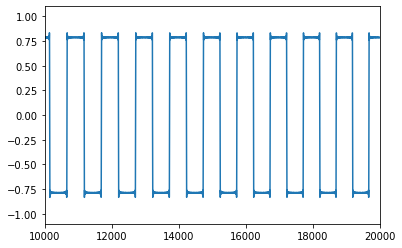

In [10]:
plt.plot(ramp_coarse_wave)
plt.xlim(left=10000, right=20000)

1 V/O at 226.27416997969522 Hz


5 HZ FM on constant 226.27416997969522 input


5 HZ FM on ramp


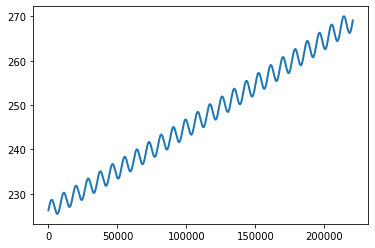

In [11]:
# simulate coarse and fine input
coarse_vin = 0
fine_vin = 0
cv_vpo_in = 2.5 # temporary override for testing


###### TEST 1 V/O @ CONSTANT F ######

# test 1 V/O at constant frequency
v_comb = coarse_vin + fine_vin + cv_vpo_in
f_vpo = vpo_to_f(f_min, v_comb)
print("1 V/O at", f_vpo, "Hz")

listen(gen_wave(WAVE_SAW, f_vpo, 1))



##### TEST FREQUENCY MODULATION ON CONSTANT PITCH #####

# simulation parameters
dur1 = 5
f_mod = 5 # modulation frequency
t = np.linspace(0, dur1, FS*dur1, endpoint=False)

# simulate FM inputs
mod_vs = 5*((np.sin(2*np.pi*t*f_mod))) # 1 V/O modulation source
mod_vs = [lin_att(x, .0025) for x in mod_vs] # apply attenuation & add DC bias

# combine inputs
f_tot = [vpo_to_f(f_min, v_comb + x) for x in mod_vs]

# output wave
print(f_mod, "HZ FM on constant", f_vpo, "input")
listen(gen_wave_w_freqs(WAVE_SAW, f_tot, dur=dur1))



##### TEST FREQUENCY MODULATION ON RAMPING PITCH #####

# simulate coarse frequency input ramp
coarse_vs = np.linspace(v_comb, v_comb + .25, len(t))

# combine inputs
f_tot = [vpo_to_f(f_min, x+y) for x,y in zip(coarse_vs, mod_vs)]

# generate wave
mod_wave = gen_wave_w_freqs(WAVE_SAW, f_tot, dur=dur1) 

print(f_mod, "HZ FM on ramp")
listen(mod_wave)
plot_wave(f_tot)

In [12]:
### TEST WAVE SHAPE MORPHING ###

w = []
for i in np.linspace(WAVE_SIN, WAVE_SQR, 100):
    w.extend(gen_wave(i, 200, .1));
listen(w)

In [13]:
#### EXAMPLE CONVERSION CV input -> ADC -> output ###
"""

coarse_gain, coarse_offs = cv_4_gain_and_offs
fine_gain, fine_offs = cv_5_gain_and_offs
cv_vpo_gain, cv_vpo_offs = cv_2_gain_and_offs

# reconstruct CV input voltage from ADC input
coarse_vin = degao(coarse_vin_adc, cv_vpo_gain, cv_vpo_offs)

cv_vpo_adc = read_cv(0)
cv_vpo_in = degao(cv_vpo_adc, cv_vpo_gain, cv_vpo_offs)

"""

'\n\ncoarse_gain, coarse_offs = cv_4_gain_and_offs\nfine_gain, fine_offs = cv_5_gain_and_offs\ncv_vpo_gain, cv_vpo_offs = cv_2_gain_and_offs\n\n# reconstruct CV input voltage from ADC input\ncoarse_vin = degao(coarse_vin_adc, cv_vpo_gain, cv_vpo_offs)\n\ncv_vpo_adc = read_cv(0)\ncv_vpo_in = degao(cv_vpo_adc, cv_vpo_gain, cv_vpo_offs)\n\n'

(100000.0, 101000.0)

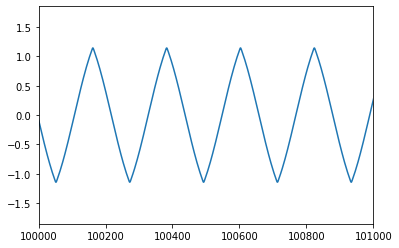

In [14]:
plt.plot(w)
plt.xlim(left=100000, right=101000)

In [15]:
dur_test = 10
w1_test = gen_wave(WAVE_SAW, vpo_to_f(150, 0), dur_test)
w2_test = gen_wave(WAVE_SAW, vpo_to_f(150, .4167), dur_test)

rmp = np.linspace(0, 1, num=dur_test*FS)
w3_test = gen_wave(WAVE_SAW, vpo_to_f(150, 1), dur_test)
w3_test = [amp*w for amp, w in zip(rmp,w3_test)]

w_out = [sum(t) for t in zip(w1_test, w2_test, w3_test)]
listen(w_out)

[]

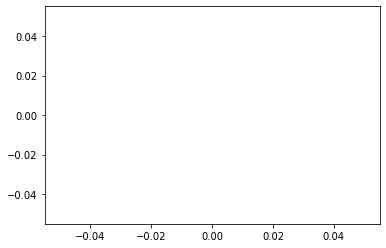

In [16]:
plt.plot()